In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm

from tqdm import tqdm

In [2]:
class FirstOrderInventory():
    def __init__(self, s = 100, T = 1, sig = 2, dt = 0.005, q = 0, gamma = 0.1, k = 1.5, A = 140):
        # Agent variables
        self.s = s
        self.x = 0
        self.q = 0
        self.t = 0
        self.T = T

        # Model variables
        self.sig = sig
        self.gamma = gamma
        self.A = A
        self.k = k

        # Simulation variables
        self.dt = dt
        self.run_simulation()

    def __repr__(self):
        return 'First Order Inventory'
    def __str__(self):
        return 'First Order Inventory'

    def _indif(self, s, q, t):
        return s - q*self.gamma*(self.sig*self.sig)*(self.T-t)
        
    def indiference(self):
        return self._indif(self.s, self.q, self.t)

    def spread(self):
        return 2/self.gamma * np.log(1+self.gamma/self.k) + self.gamma*(self.sig*self.sig)*(self.T-self.t)
    
    def post_depth(self):
        delta_bid = self.s - (self.indiference() - self.spread()/2)
        delta_ask = (self.indiference() + self.spread()/2) - self.s
        return np.array([delta_bid, delta_ask])

    def fill_intensity(self):
        return self.A*np.exp(-self.k*self.post_depth())

    def run_simulation(self):
        self.s_array = [self.s]
        self.x_array = [self.x]
        self.q_array = [self.q]
        self.t_array = [self.t]

        self.post_depth_array = []
        self.fills = []
        
        while self.t<self.T:
            # Agents decision
            post_depth = self.post_depth()
            fill_intensity = self.fill_intensity()
            fill_probability = self.fill_intensity()*self.dt

            self.post_depth_array.append(post_depth)

            # Update market and agent variables
            self.s += self.sig*np.sqrt(self.dt)*np.random.normal() # np.random.choice([-1, 1]) 
            self.t += self.dt
            
            if np.random.uniform() < fill_probability[0]:
                self.q += 1
                self.x -= self.s - post_depth[0]
                self.fills.append(('bid', self.t, self.s - post_depth[0]))
                
            if np.random.uniform() < fill_probability[1]:
                self.q -= 1
                self.x += self.s + post_depth[1]
                self.fills.append(('ask', self.t, self.s + post_depth[1]))

            self.s_array.append(self.s)
            self.x_array.append(self.x)
            self.q_array.append(self.q)
            self.t_array.append(self.t)
            
        self.s_array, self.x_array, self.q_array, self.t_array = map(np.array,
        [self.s_array, self.x_array, self.q_array, self.t_array])

        self.post_depth_array, self.fills = map(np.array,
        [self.post_depth_array, self.fills])

    def summary(self):
        print('----- Simulation Summary -----')
        print(f'Final MtM Wealth: {round(self.x + self.q*self.s, 2)}')
        print(f'Final Inventory: {self.q}')
        print('----- ----- ------- ----- -----')
    
    def plot_run(self, save=None):
        
        fig, ax = plt.subplots(1,1, figsize=(20,10))
        ax.set_xlim(0, self.T)

        ax.plot(self.t_array, self.s_array, c='black', lw=2, label='Market Price')

        indif_price_series = self._indif(self.s_array, self.q_array, self.t_array)
        ax.plot(self.t_array, indif_price_series, c='lightgreen', ls='--', lw=3, label='Indiference Price')

        posted_bid_series = self.s_array[:-1]-self.post_depth_array[:, 0]
        posted_ask_series = self.s_array[:-1]+self.post_depth_array[:, 1]

        ax.plot(self.t_array[:-1], posted_bid_series, color='darkblue')
        ax.plot(self.t_array[:-1], posted_ask_series, color='darkred')
        ax.fill_between(self.t_array[:-1], self.s_array[:-1], posted_bid_series, color=cm.coolwarm.get_under(), label='Bid Depth')
        ax.fill_between(self.t_array[:-1], self.s_array[:-1], posted_ask_series, color=cm.coolwarm.get_over(), label='Ask Depth')

        ax_inventory = fig.add_axes([0.12, -0.1, 0.98, 0.1])
        ax_inventory.set_title('Inventory')
        ax_inventory.set_xticks([])
        ax_inventory.set_yticks([])
        
        img = ax_inventory.imshow(self.q_array.reshape(1,-1), norm=colors.CenteredNorm(), cmap='coolwarm', aspect=10)
        plt.colorbar(img, aspect=10, ax=ax_inventory)

        ax_depth_imbalance = fig.add_axes([0.12, -0.25, 0.98, 0.1])
        ax_depth_imbalance.set_title('Depth Imbalance')
        ax_depth_imbalance.set_xticks([])
        ax_depth_imbalance.set_yticks([])

        depth_imbalance = (self.post_depth_array[:, 0]-self.post_depth_array[:, 1])/(self.post_depth_array[:, 0]+self.post_depth_array[:, 1])
        img = ax_depth_imbalance.imshow(depth_imbalance.reshape(1,-1), vmin=-1, vmax=1, cmap='coolwarm', aspect=10)
        plt.colorbar(img, ticks=[-1,0,1], aspect=10, ax=ax_depth_imbalance)

        ax_spread = fig.add_axes([0.12, -0.4, 0.98, 0.1])
        ax_spread.set_title('Spread')
        ax_spread.set_xticks([])
        ax_spread.set_yticks([])

        spread = (self.post_depth_array[:, 0]+self.post_depth_array[:, 1])
        img = ax_spread.imshow(spread.reshape(1,-1), cmap='coolwarm', aspect=10)
        plt.colorbar(img, aspect=10, ax=ax_spread)

        ax.legend()
        
        if save:
            plt.savefig(save, bbox_inches='tight')

In [3]:
class FirstOrderSymmetric(FirstOrderInventory):
    def __init__(self, s = 100, T = 1, sig = 2, dt = 0.005, q = 0, gamma = 0.1, k = 1.5, A = 140):
        super().__init__(s, T, sig, dt, q, gamma, k, A)

    def __repr__(self):
        return 'First Order Symmetric'
    def __str__(self):
        return 'First Order Symmetric'
        
    def _indif(self, s, q, t):
        return s

class NaiveSymmetric(FirstOrderInventory):
    def __init__(self, s = 100, T = 1, sig = 2, dt = 0.005, q = 0, gamma = 0.1, k = 1.5, A = 140):
        super().__init__(s, T, sig, dt, q, gamma, k, A)

    def __repr__(self):
        return 'First Order Symmetric'
    def __str__(self):
        return 'First Order Symmetric'
        
    def _indif(self, s, q, t):
        return s
    def spread(self):
        return 2/self.gamma * np.log(1+self.gamma/self.k)

In [4]:
class MonteCarloStatistics():
    def __init__(self, M, simulation_instance):
        self.simulation_instance = simulation_instance
        self.name = str(simulation_instance)
        
        pnlT_array = []
        qT_array = []

        inventory_ts_array = []
        depth_ts_array = []

        for _ in tqdm(range(M)):
            simulation = type(simulation_instance)(simulation_instance.s, simulation_instance.T, simulation_instance.sig, simulation_instance.dt, simulation_instance.q, simulation_instance.gamma, simulation_instance.k, simulation_instance.A)
            qT_array.append(simulation.q_array[-1])
            pnlT_array.append(simulation.x + simulation.q*simulation.s)
            inventory_ts_array.append(simulation.q_array)
            depth_ts_array.append(simulation.post_depth_array)
            

        self.qT_array = np.array(qT_array)
        self.pnlT_array = np.array(pnlT_array)

        self.inventory_ts_array = np.array(inventory_ts_array)
        self.depth_ts_array = np.array(depth_ts_array)

    def get_results(self):
        return pd.DataFrame.from_dict({'qT': self.qT_array, 'PnL': self.pnlT_array})

    def get_statistics(self):
        df_results = pd.DataFrame.from_dict({self.name: [round(self.pnlT_array.mean(), 2), round(self.pnlT_array.std(), 2), round(self.qT_array.mean(), 2), round(self.qT_array.std(), 2)]}, columns=['E[Profit]', 'std(Profit)', 'E[Final Q]', 'std(Final Q)'], orient='index')
        return df_results

----- Simulation Summary -----
Final MtM Wealth: 64.16
Final Inventory: -5
----- ----- ------- ----- -----


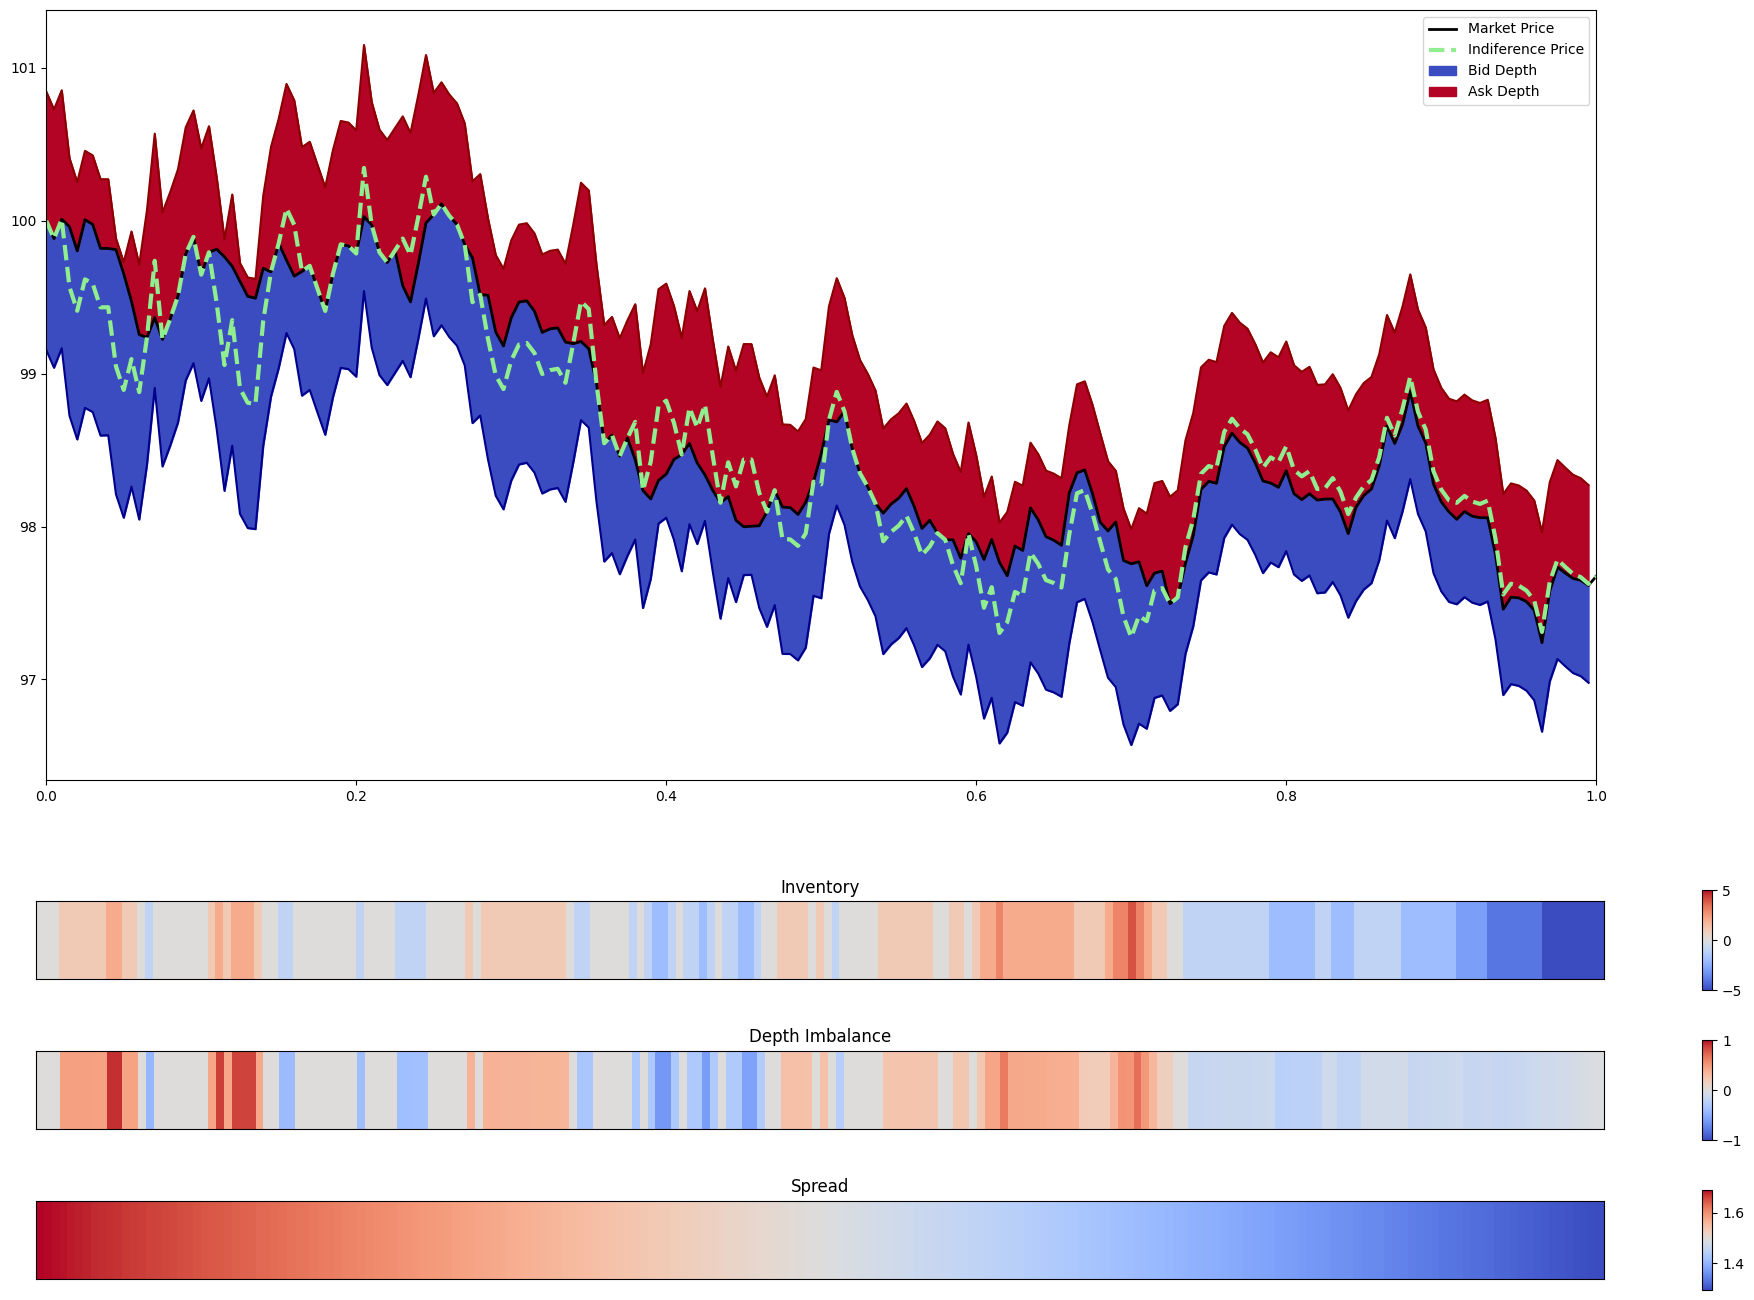

In [5]:
simulation = FirstOrderInventory()

simulation.summary()
simulation.plot_run(save='Fig1.pdf')

----- Simulation Summary -----
Final MtM Wealth: 57.43
Final Inventory: 0
----- ----- ------- ----- -----


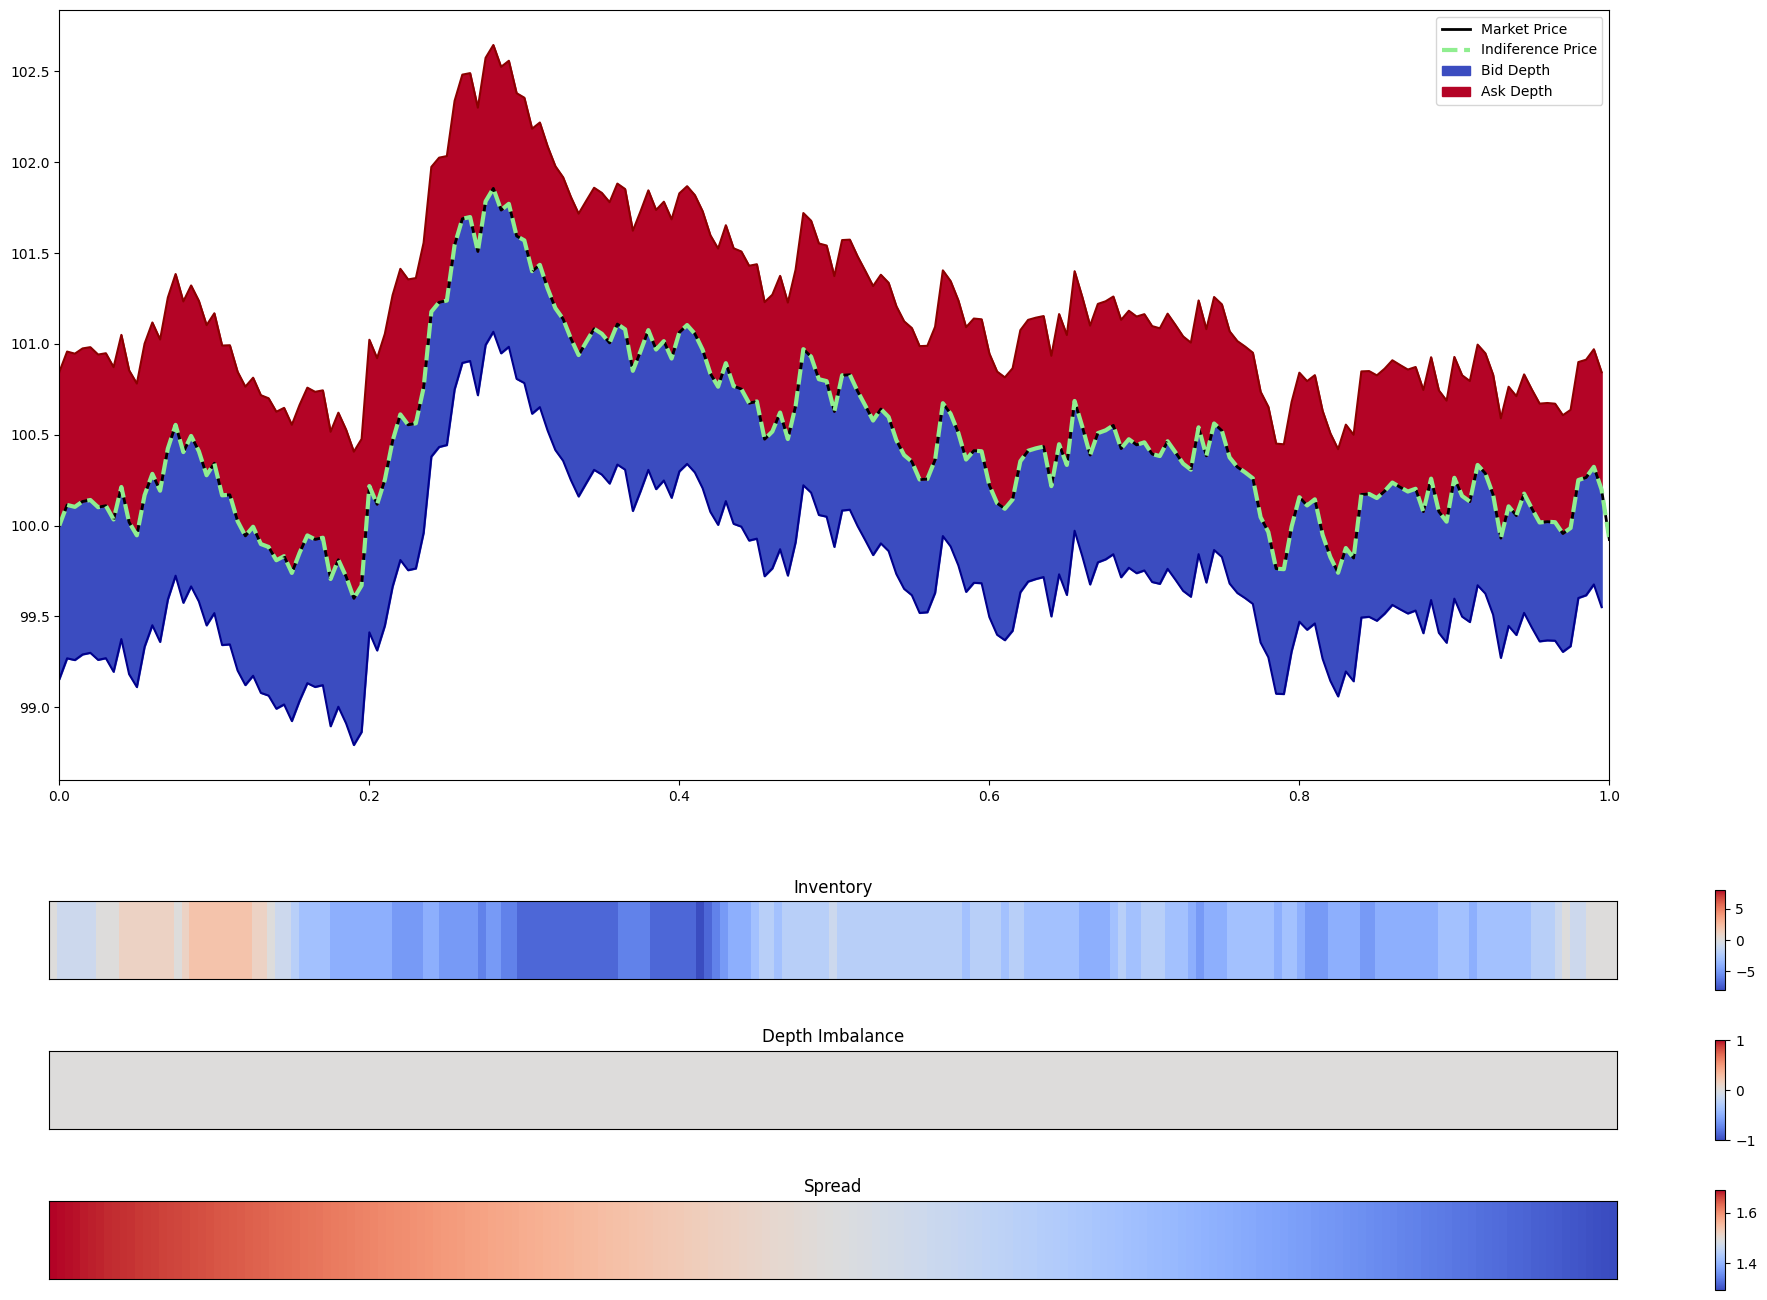

In [6]:
simulation = FirstOrderSymmetric()

simulation.summary()
simulation.plot_run()

In [7]:
MC_Inventory = MonteCarloStatistics(1000, FirstOrderInventory())
MC_Symmetric = MonteCarloStatistics(1000, FirstOrderSymmetric())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 281.85it/s]


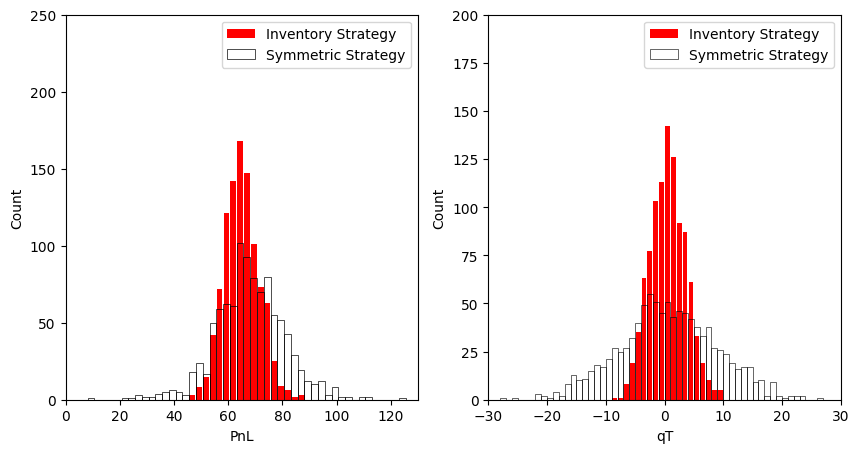

In [8]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

sns.histplot(MC_Inventory.get_results()['PnL'], label = 'Inventory Strategy', facecolor='red', edgecolor='None', binwidth=2.5, shrink=0.82, ax=ax[0])
sns.histplot(MC_Symmetric.get_results()['PnL'], label = 'Symmetric Strategy', facecolor='None', edgecolor='black', binwidth=2.5, ax=ax[0])
ax[0].set_xlim([0, 130])
ax[0].set_ylim([0, 250])
ax[0].legend()

sns.histplot(MC_Inventory.get_results()['qT'], label = 'Inventory Strategy', facecolor='red', edgecolor='None', binwidth=1, shrink=0.82, ax=ax[1])
sns.histplot(MC_Symmetric.get_results()['qT'], label = 'Symmetric Strategy', facecolor='None', edgecolor='black', binwidth=1, ax=ax[1])
ax[1].set_xlim([-30, 30])
ax[1].set_ylim([0, 200])
ax[1].legend()

plt.savefig('Fig2.pdf',  bbox_inches='tight')

In [9]:
MC_Inventory_lowgamma = MonteCarloStatistics(1000, FirstOrderInventory(gamma=0.01))
MC_Symmetric_lowgamma = MonteCarloStatistics(1000, FirstOrderSymmetric(gamma=0.01))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 276.69it/s]


In [ ]:
MC_Inventory_highgamma = MonteCarloStatistics(1000, FirstOrderInventory(gamma=0.5))
MC_Symmetric_highgamma = MonteCarloStatistics(1000, FirstOrderSymmetric(gamma=0.5))

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 727/1000 [00:02<00:00, 287.20it/s]

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

sns.histplot(MC_Inventory_lowgamma.get_results()['PnL'], label = 'Inventory Strategy', facecolor='red', edgecolor='None', binwidth=2.5, shrink=0.82, ax=ax[0])
sns.histplot(MC_Symmetric_lowgamma.get_results()['PnL'], label = 'Symmetric Strategy', facecolor='None', edgecolor='black', binwidth=2.5, ax=ax[0])
ax[0].set_xlim([-50, 150])
ax[0].set_ylim([0, 250])
ax[0].legend()

sns.histplot(MC_Inventory_highgamma.get_results()['PnL'], label = 'Inventory Strategy', facecolor='red', edgecolor='None', binwidth=2.5, shrink=0.82, ax=ax[1])
sns.histplot(MC_Symmetric_highgamma.get_results()['PnL'], label = 'Symmetric Strategy', facecolor='None', edgecolor='black', binwidth=2.5, ax=ax[1])
ax[1].set_xlim([-50, 150])
ax[1].set_ylim([0, 250])
ax[1].legend()

plt.savefig('Fig5.pdf',  bbox_inches='tight')

In [ ]:
pd.concat([MC_Inventory_lowgamma.get_statistics(), MC_Symmetric_lowgamma.get_statistics()])

In [ ]:
pd.concat([MC_Inventory_highgamma.get_statistics(), MC_Symmetric_highgamma.get_statistics()])